<a href="https://colab.research.google.com/github/Azalea2406/DeepFake-Detection/blob/main/MI%26DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#importing files


In [1]:
from google.colab import files
files.upload()



Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"mekalamadhumitha","key":"a80b4b704b447bf87e80ad9469b9019b"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d manjilkarki/deepfake-and-real-images


Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown
deepfake-and-real-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import zipfile

with zipfile.ZipFile("deepfake-and-real-images.zip", 'r') as zip_ref:
    zip_ref.extractall("deepfake_dataset")


In [5]:
!mkdir -p "/content/drive/My Drive/DeepfakeDetection"
!cp -r deepfake_dataset/* "/content/drive/My Drive/DeepfakeDetection"


In [7]:
import os
dataset_path = "/content/drive/My Drive/DeepfakeDetection/Dataset/Train"

real_path = os.path.join(dataset_path, "Real")
fake_path = os.path.join(dataset_path, "Fake")

print("Real images:", len(os.listdir(real_path)))
print("Fake images:", len(os.listdir(fake_path)))



Real images: 70001
Fake images: 70001


In [8]:
# Install required packages (if not already installed)
!pip install tensorflow --quiet


In [9]:
import os
import numpy as np
import cv2
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split


In [10]:
IMG_SIZE = 224
data = []
labels = []

real_dir = os.path.join(dataset_path, "Real")
fake_dir = os.path.join(dataset_path, "Fake")

# Limit how many images we load
MAX_IMAGES_PER_CLASS = 500

# Load real images
for i, img_name in enumerate(os.listdir(real_dir)):
    if i >= MAX_IMAGES_PER_CLASS:
        break
    img_path = os.path.join(real_dir, img_name)
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        data.append(img)
        labels.append(0)

# Load fake images
for i, img_name in enumerate(os.listdir(fake_dir)):
    if i >= MAX_IMAGES_PER_CLASS:
        break
    img_path = os.path.join(fake_dir, img_name)
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        data.append(img)
        labels.append(1)

print("Total samples loaded:", len(data))



Total samples loaded: 1000


In [11]:
# Convert to NumPy arrays
data = np.array(data)
labels = np.array(labels)

# Normalize image pixels (0 to 1)
data = data / 255.0

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)


Training set: (800, 224, 224, 3)
Testing set: (200, 224, 224, 3)


In [12]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [13]:
# Input shape matches image size and channels (RGB)
input_tensor = Input(shape=(224, 224, 3))

# Load EfficientNetB0 without the top layer
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=input_tensor)

# Freeze base model layers (optional for fast training)
base_model.trainable = False

# Custom head
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=output)


In [14]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [15]:
# Early stopping to avoid overfitting
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=10,
                    batch_size=32,
                    callbacks=[early_stop])


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5331 - loss: 0.7116

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


25/25 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.5320 - loss: 0.7119 - val_accuracy: 0.4800 - val_loss: 0.6939
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.5051 - loss: 0.7059 - val_accuracy: 0.5200 - val_loss: 0.6930
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.5358 - loss: 0.6974 - val_accuracy: 0.5200 - val_loss: 0.6924
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.4697 - loss: 0.7108 - val_accuracy: 0.5200 - val_loss: 0.6930
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.4904 - loss: 0.7072 - val_accuracy: 0.4800 - val_loss: 0.6935
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.5317 - loss: 0.6946 - val_accuracy: 0.4800 - val_loss: 0.6950


In [16]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")


7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5398 - loss: 0.6906
Test Accuracy: 52.00%


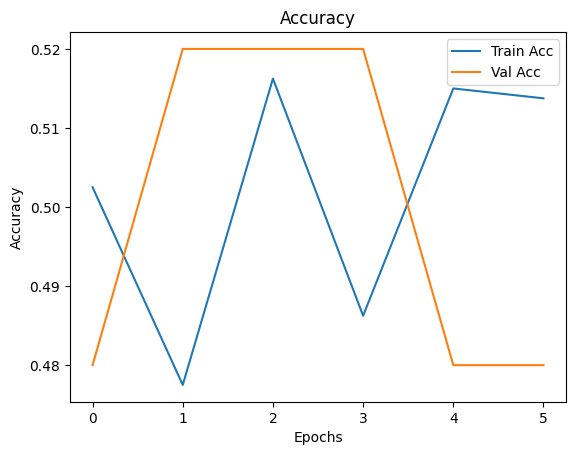

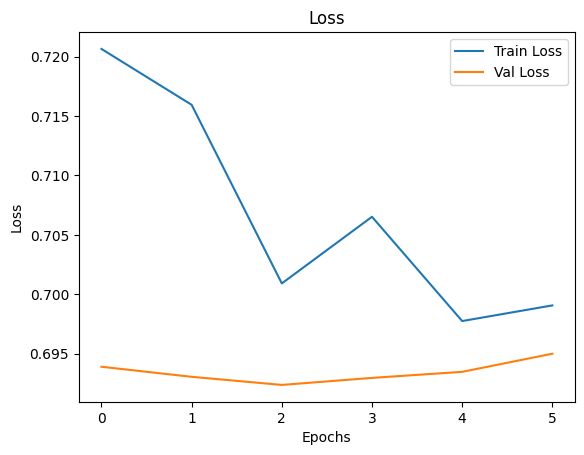

In [17]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [18]:
model.save("/content/drive/My Drive/DeepfakeDetection/efficientnet_model.keras")
print("Model saved in Keras format to Google Drive ✅")



Model saved in Keras format to Google Drive ✅


In [19]:
!git clone https://github.com/Azalea2406/DeepFake-Detection.git

Cloning into 'DeepFake-Detection'...
remote: Enumerating objects: 173297, done.
remote: Total 173297 (delta 0), reused 0 (delta 0), pack-reused 173297 (from 2)
Receiving objects: 100% (173297/173297), 1.24 GiB | 23.77 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Updating files: 100% (190384/190384), done.
